In [1]:
import numpy 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from numpy import diff
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize
import lal
from pycbc import waveform, types
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize

In [2]:
### Calling NR waveforms (SXS simulations used)

(array([  980,   981,   982, ..., 14555, 14556, 14557]),)
13578
time: 3278.9682914988716 
 index: 12054 
 length: 13578


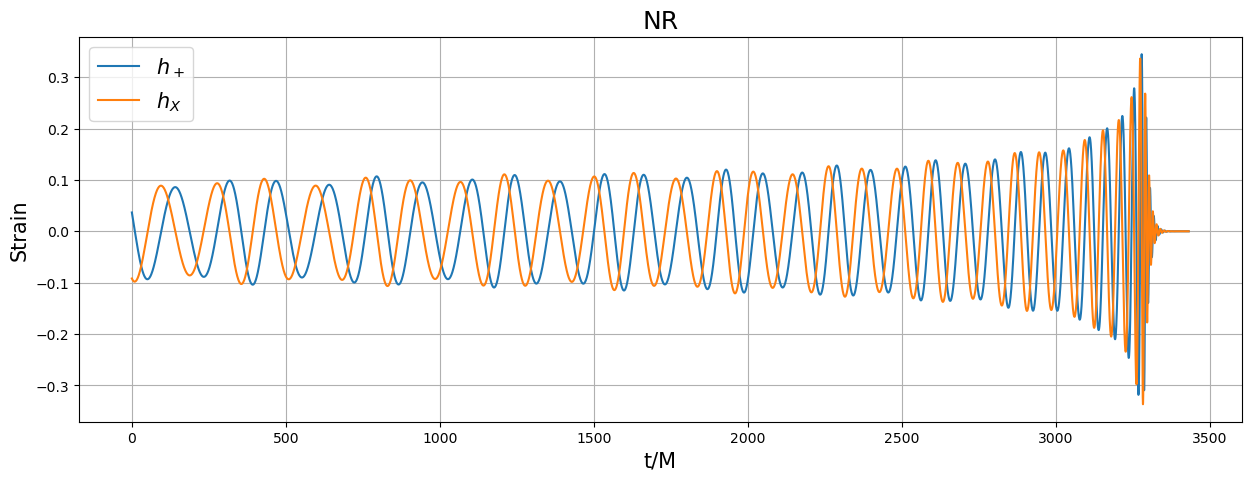

In [3]:
#modify filename to include directory path to file, 
#for e.g. '/home/SXSfiles/1365_rhOverM_Asymptotic_GeometricUnits_CoM.h5' 
simulation = '1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5'  
tref = 640.0 #tref is the start time of usable SXS waveforms, check metadata of simulation to obtain it
sims = simulation.split('_')[0]
lp = 2 # change accordingly
mp = 2
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File('/home/pratul/Downloads/Project/NR_data/'+simulation, 'r') as hdf:     
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]


plt.figure(figsize=(15,5))
plt.plot(x1,y1,label='$h_+$')
plt.plot(x1,z1,label='$h_X$')
plt.title("NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

print('time:',x1[np.argmax(amp)],'\n index:',np.argmax(amp),'\n length:',len(amp))

### Parameters for generating inspiral waveform

In [4]:
# Window:  time_NR[0] to -1000M:
# M = 30M_Sun
# q = 2
# e = 0.1217557644932139
# f = 20.000932607017745
# NR simulation : SXS:BBH:1364

# Window:  -2000M to -1000M:
# M = 30M_Sun
# q = 2
# e = 0.1208977180370708
# f = 19.999214896912523
# NR simulation : SXS:BBH:1364

In [5]:
# initial frequency from table
total_mass = 30
freq = 16.68
xl = (total_mass*MTSUN_SI*math.pi*freq)**(2/3)

In [6]:
print(xl)

0.03913912683431347


In [7]:
#these parameters have been obtained from Hinder et.al. 2019
q=2
eref=0.18
cl=lref=-0.181
e0=0.172 #initial eccentricity at xlow, will change if xlow changes
eta=neu=nu=q/(1+q)**2 
xref=0.075 
xlow=xl # xlow is either xl or 0.045 #xlow can be chosen to be any value, we have chosen 0.045 to be the start of our hybrids
G=c=M=d=1
d0=1
M0=1
M2=M/(1+q)
M1=M2*q
modetopolfac=4*(5/(64*np.pi))**(1/2) # 22 mode factor

#lref = (lref + np.pi) % (2 * np.pi) - np.pi  #use only for SXS:BBH:1167
#cl = lref

hl2m2pVec=y1
hl2m2cVec=z1
tVec=x1
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI;
hpVec_SI=hl2m2pVec*G_SI*M_SI/D_SI/C_SI/C_SI;
hcVec_SI=hl2m2cVec*G_SI*M_SI/D_SI/C_SI/C_SI;

3.6949538151940316e-06
13578 4573 3431.2612124305097


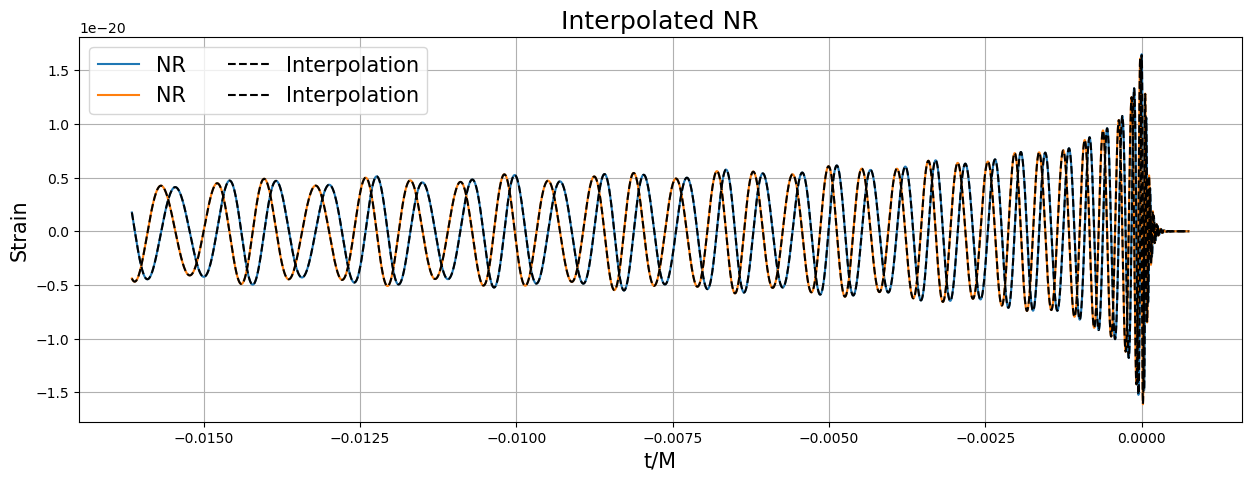

In [8]:
delta_t_NR=np.max(abs(np.diff(tVec_SI)))   
print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
#hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
#hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=-tVec_NR[mergIdx_NR]) ## setting merger to t = 0 if needed
hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=-tVec_NR[mergIdx_NR]) ## setting merger to t = 0 if needed

tVec_NR = tVec_NR - tVec_NR[mergIdx_NR] ## setting merger to t = 0 if needed

plt.figure(figsize=(15,5))
plt.plot(tVec_SI-tVec_SI[np.argmax(abs(hpVec_SI - 1j* hcVec_SI))],hpVec_SI,label='NR') 
plt.plot(tVec_SI-tVec_SI[np.argmax(abs(hpVec_SI - 1j* hcVec_SI))],hcVec_SI,label='NR') 

#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(hpVec_NR.sample_times,hpVec_NR,'k--',label='Interpolation')
plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')
plt.plot(tVec_NR,hc_NR_int,'k--',label='Interpolation')
plt.title("Interpolated NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15},ncol=2)
print(len(t),len(hpVec_NR),tVec[-1])

In [9]:
phiC=phase_NR[mergIdx_NR]         
#tC_NR=hpVec_NR.sample_times[mergIdx_NR]
#phiC=phase_NR[len(hpVec_NR)]         
#tC_NR=max(hpVec_NR.sample_times)
tC_NR = hpVec_NR.sample_times[np.argmax(abs(hpVec_NR - 1j*hcVec_NR))]
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma= 0.577215664901

%run GW_functions.ipynb
conv=M*MTSUN_SI               #total mass (needed to convert PN time t to t/M)

#Formula to compute f from a given x
def freq(i):
    return(i**(3/2)/(M*MTSUN_SI*math.pi))
 
f_low=freq(xlow)            #Lower frequency of EccTD wf which is in our hands
f_ref=freq(xref)            #Ref frequency of EccTD wf

####################################################

#Calculating ecc at xlow for generating EccTD wf-->eccentricity evolution Eq. (4.17a,b) Moore et. al.(2016)

x=xlow                         #x=point where eccentricity is required
v=math.sqrt(x)
vref=math.sqrt(xref)
xie=v**3
xiref=vref**3

#Gives e at xie with b.c.--> e=eref when xie=xiref

e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta) # this is using Moore evolution equation
#not using this eccentricity since we have used EccentricTD evolution to generate the initial eccentricity(e0) values

print(e) 
print(f_low)

0.5713053396994988
500.4000000000001


In [10]:
print(tC_NR,hpVec_NR.sample_times[-1])

-6.99278141727544e-06 0.0007430828430671117


### Generating EccentricTD

In [11]:
hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                         delta_t=delta_t_common, 
                         f_lower=f_low, 
                         eccentricity=e0,
                         distance=d)

43162


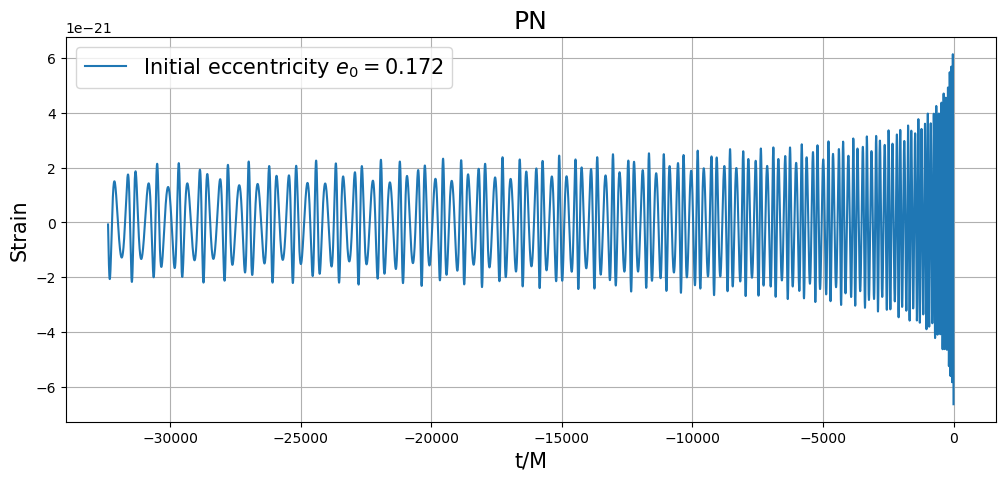

In [12]:
plt.figure(figsize=(12,5))
tVec_PN_shifted=tC_NR+hpVec_PN.sample_times#-hpVec_PN.sample_times[-1]
plt.plot(tVec_PN_shifted/conv,hpVec_PN,label='Initial eccentricity $e_0=%1.3f$' %e0)
plt.title("PN",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
print(len(hpVec_PN))

In [13]:
print(tVec_PN_shifted[-1])

-1.068816382768234e-05


In [14]:
print(len(hpVec_PN))

43162


### obtaining EccentricTD phase

In [15]:
phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))

In [17]:
tVec_PN_GM=tVec_PN_shifted/conv
tVec_NR_GM=tVec_NR/conv
hpVec_PN_GM=np.array(hpVec_PN)/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))
hcVec_PN_GM=np.array(hcVec_PN)/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))

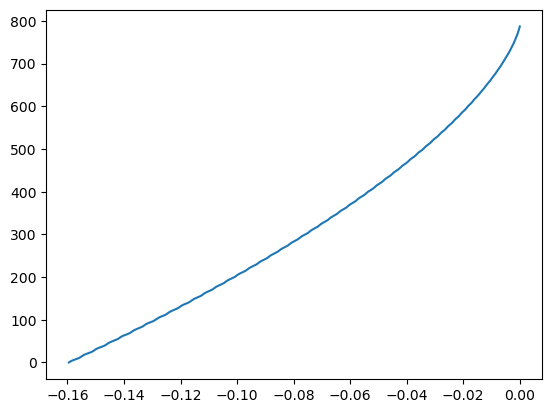

In [18]:
plt.plot(hpVec_PN.sample_times,phase_EccTD)

In [19]:
tC_NR=tC_NR/conv
tC_NR
#tVec_PN_GM[-1]

-1.4197125711141878

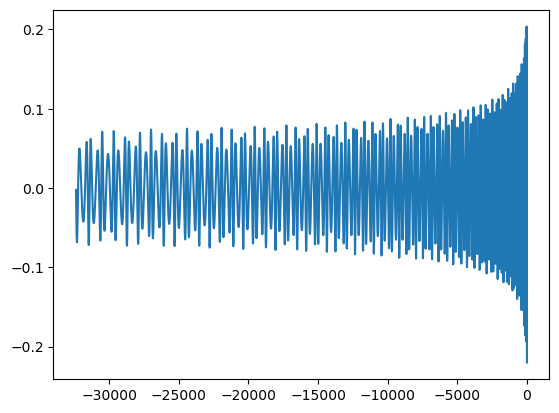

In [20]:
plt.plot(tVec_PN_GM,hpVec_PN_GM)

In [21]:
# use only if EccTD hybrids needed

#hlm_real = np.real(hpVec_PN_GM - 1j*hcVec_PN_GM)
#hlm_imag = np.imag(hpVec_PN_GM - 1j*hcVec_PN_GM)

### Obtaining parameters for generating Ebersold+ amplitudes

In [22]:
#tVec_PN_GM = np.arange(-30000, -100, 10)

tVec_PN=tVec_PN_GM
tC_NR=tC_NR

xi_ref=xref**(3/2)
v_ref=xi_ref**(1/3)
#input initial params
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
#e0=(eref*(xi_ref/xi0)**(19/18))*(epsilon(xi0, eta)/epsilon(xi_ref, eta))
l0=mean_anomaly(xi_ref, xi0, lref, eta, e0)
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

In [23]:
print(tC_NR-tVec_PN)

[3.23788225e+04 3.23780723e+04 3.23773221e+04 ... 2.25059596e+00
 1.50042631e+00 7.50256665e-01]


In [24]:
xiVec=(np.pi*M*fVec)
#print('xiVec:', xiVec)
xVec=xiVec**(2/3)
print('xVec:', xVec)
vVec=xiVec**(1/3)

xVec: [0.03904733 0.03904757 0.03904781 ...        nan        nan        nan]


/home/pratul/anaconda3/envs/igwn-py38-prayush/lib/python3.8/site-packages/pycbc/types/array.py:435: RuntimeWarning: invalid value encountered in power
  return self._data ** other


In [25]:
#selct +ve frequencies
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=xiVec[plotIdx2]
xVec=xVec[plotIdx2]
vVec=vVec[plotIdx2]
maxPNidx=len(xVec)
print(maxPNidx)

43099


In [26]:
len(xVec), len(phase_EccTD)

(43099, 43162)

### Ebersold+ amplitudes

In [27]:
j=0
omega=[]
hlm_real=[]
hlm_imag=[]
hlm_abs=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi= mp*New_phase_TT2(x, x0, e0, 0.0, 0.0, 0.0, M, nu, Delta)+2*W(xie, xi0, eta, e0, l) # New TT2 phase (Omkar)
    #psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    
    #change according to the hlm required, check GW_functions.ipynb for the function definitions and arguements
    h=amplitude_22(xi,x,nu,Delta,e)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm0 = hlm *M0/d0
    hlm_real.append(hlm0.real)
    hlm_imag.append(hlm0.imag)
    hlm_abs.append(abs(hlm0))
print((hlm_real))

100%|███████████████████████████████████| 43099/43099 [00:28<00:00, 1503.19it/s]

[-0.009173176396719093, -0.03102053307137723, -0.030815363295952605, -0.030608530723449122, -0.030400045389454605, -0.0301899172853951, -0.02997815635930704, -0.029764772516922354, -0.02954977562247064, -0.02933317549991317, -0.02911498193367333, -0.028895204669779486, -0.028673853417064955, -0.028450937847956305, -0.028226467599827092, -0.028000452275911837, -0.027772901446531384, -0.027543824650214977, -0.02731323139488287, -0.02708113115901208, -0.026847533392800146, -0.026612447519571075, -0.026375882936660027, -0.026137849017061857, -0.025898355110453897, -0.025657410544548676, -0.025415024626442878, -0.025171206643880388, -0.024925965866624877, -0.024679311547852793, -0.024431252925405596, -0.024181799223352826, -0.023930959653209474, -0.02367874341551385, -0.02342515970124903, -0.023170217693106118, -0.022913926567165312, -0.022656295494321164, -0.02239733364170121, -0.022137050174224383, -0.021875454256152824, -0.0216125550526653, -0.02134836173114471, -0.021082883463137265, -0

In [28]:
mp, j

(2, 43099)

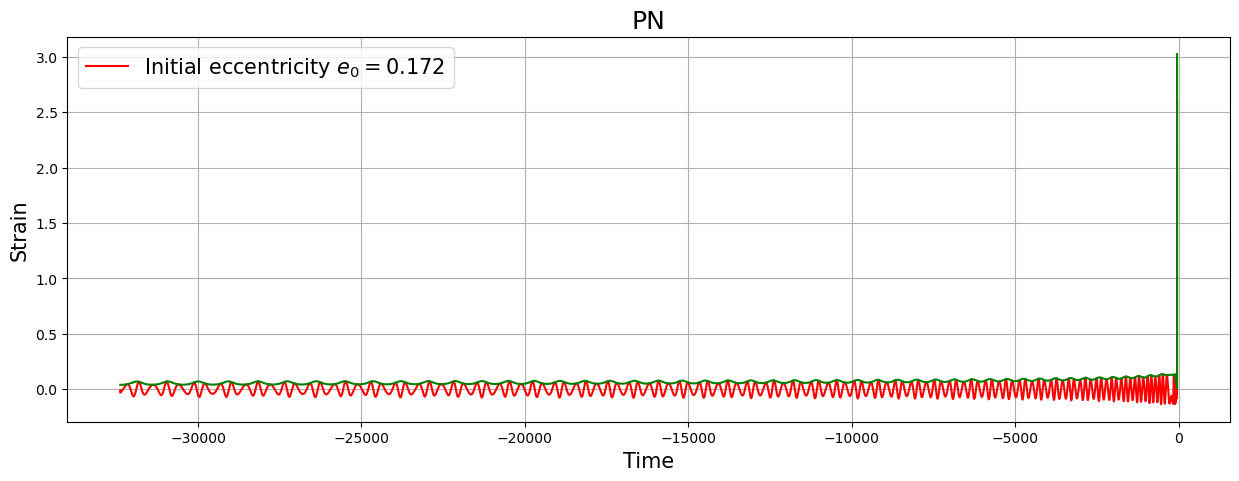

In [29]:
plt.figure(figsize=(15,5))
#print(hlm_real[:])
plt.plot(tVec_PN_GM[:maxPNidx],hlm_real[:],'r',label='Initial eccentricity $e_0=%1.3f$' %e0)
plt.plot(tVec_PN_GM[:maxPNidx],hlm_abs[:],'g')
plt.title("PN", fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("Time", fontsize=15)
#plt.xlim(xmin=-500)
#plt.xlim(xmax=2500)
#plt.ylim(-0.5e0,0.5e0)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
#plt.savefig("4.png",dpi=300)

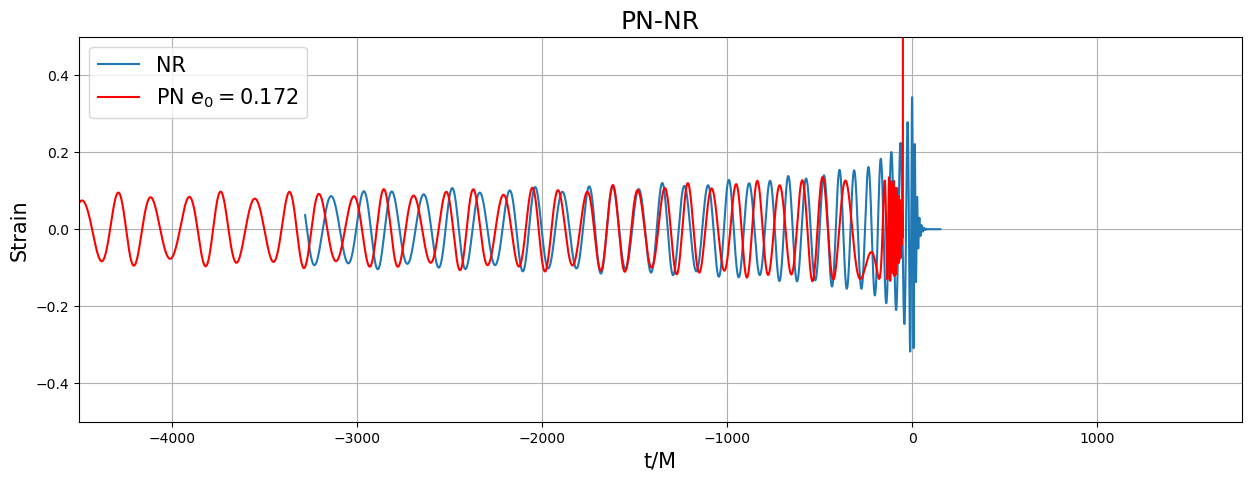

In [30]:
plt.figure(figsize=(15,5))
plt.plot(tVec_NR_GM, hpVec_NR/(G_SI*M_SI/D_SI/C_SI/C_SI), label='NR')
plt.plot(tVec_PN_GM[:maxPNidx],hlm_real,'r',label='PN $e_0=%1.3f$' %e0) # Ebersold
#plt.plot(tVec_PN_GM[:],hlm_real,'r',label='PN $e_0=%1.3f$' %e0) # EccTD
#plt.plot(tVec_PN_GM[:maxPNidx],hlm_imag,'r',label='PN $e_0=%1.3f$' %e0) 
plt.ylim(ymax=0.5)
plt.ylim(ymin=-0.5)
plt.xlim(xmin=-4500)
#plt.xlim(xmax=6700)
plt.title("PN-NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

### Hybridization routine

In [31]:
## merger at zero
t1Idx_NR=np.where(tVec_NR_GM>=-2000.0)[0][0]
t1Idx_PN=np.where(tVec_PN_GM>=-2000.0)[0][0]

t2Idx_NR=np.where(tVec_NR_GM>=-1000.0)[0][0]
t2Idx_PN=np.where(tVec_PN_GM>=-1000.0)[0][0]

##merger at t>0
t1Idx_NR=np.where(tVec_NR_GM>=1000)[0][0]
t1Idx_PN=np.where(tVec_PN_GM>=1000)[0][0]

t2Idx_NR=np.where(tVec_NR_GM>=2000.0)[0][0]
t2Idx_PN=np.where(tVec_PN_GM>=2000.0)[0][0]

In [32]:
print(tVec_NR_GM[t1Idx_NR],tVec_PN_GM[t1Idx_PN])

-1999.317556849273 -1999.8717444413414


In [33]:
stretch=abs(tVec_NR_GM[t1Idx_NR]-tVec_NR_GM[t2Idx_NR])
print('NR matching window in t/M:',stretch)
print('NR matching indices:',t1Idx_NR,'\t',t2Idx_NR)

stretch=abs(tVec_PN_GM[t1Idx_PN]-tVec_PN_GM[t2Idx_PN])
print('\nPN matching window in t/M:',stretch)
print('PN matching indices:',t1Idx_PN,'\t',t2Idx_PN)

NR matching window in t/M: 999.6587784246365
NR matching indices: 1705 	 3037

PN matching window in t/M: 999.9761420762151
PN matching indices: 40498 	 41831


In [34]:
print(t2Idx_NR - t1Idx_NR,t2Idx_PN-t1Idx_PN)

1332 1333


In [35]:
hpVec_NR_GM=hp_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI)
hcVec_NR_GM=hc_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI)

In [36]:
if (t2Idx_NR - t1Idx_NR)<(t2Idx_PN-t1Idx_PN):
    t2Idx_NR = t2Idx_NR+1

In [37]:
hpVec_NR_crop=hpVec_NR_GM[t1Idx_NR:t2Idx_NR]
hcVec_NR_crop=hcVec_NR_GM[t1Idx_NR:t2Idx_NR]
tVec_NR_crop=tVec_NR_GM[t1Idx_NR:t2Idx_NR]

def PN_crop(pnshiftIdx):
    hpVec_PN_crop=np.array(hlm_real[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx])
    #hpVec_PN_crop=np.array(hlm_imag[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx])
    tVec_PN_crop=tVec_PN_GM[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx]
    return(tVec_PN_crop, hpVec_PN_crop)

In [42]:
def deltaPNNR(param_Vec, h_NR_crop, h_PN_crop):
    #return(np.sum(abs(h_NR_crop-param_Vec[2]*h_PN_crop*((np.e)**(1j*(param_Vec[0]+param_Vec[1]))))))
    #print(len(h_PN_crop))
    #set_len = min(len(h_PN_crop),len(h_NR_crop))
    #print(set_len)
    return(np.sum(abs(h_NR_crop-h_PN_crop*((np.e)**(1j*(param_Vec[0]+param_Vec[1]))))))

In [43]:
timeshiftIdxVec=np.arange(-500,500,1)

param_Vec_initial=[np.pi/2,0]
deltaVec=[]
paramVecmin=[]

for timeshiftIdx in timeshiftIdxVec:
    tVec_PN_crop, hpVec_PN_crop=PN_crop(timeshiftIdx)
    param_Vec_minimized = scipy.optimize.fmin(func=deltaPNNR, x0=param_Vec_initial, args=(hpVec_NR_crop,hpVec_PN_crop))
    deltaVec.append(deltaPNNR(param_Vec_minimized,hpVec_NR_crop,hpVec_PN_crop))
    paramVecmin.append(param_Vec_minimized)

Optimization terminated successfully.
         Current function value: 102.077465
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 101.497660
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 100.928880
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 100.365739
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 99.809533
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 99.265244
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 98.730281
         Iterations: 28
         Function evaluations: 53
Optimization terminated

Optimization terminated successfully.
         Current function value: 112.738721
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 111.343166
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 109.938714
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 108.513957
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 107.077940
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 105.632143
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 104.169326
         Iterations: 28
         Function evaluations: 53
Optimization termina

Optimization terminated successfully.
         Current function value: 93.241527
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 93.731382
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 94.213778
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 94.695532
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 95.174604
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 95.666047
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 96.165865
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 64.571816
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 65.200803
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 66.064149
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 67.236745
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 68.647998
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 70.332595
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 72.341797
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 33.130957
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 32.263728
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 31.443393
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 30.756131
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 30.514513
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 30.587413
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 30.947468
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 89.960592
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 86.982255
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 83.973321
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 80.940485
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 77.881447
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 74.798970
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 71.693962
         Iterations: 29
         Function evaluations: 54
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 131.128975
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 131.018117
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 128.547316
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 126.032823
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 123.468101
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 120.860851
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 118.208681
         Iterations: 29
         Function evaluations: 54
Optimization termina

In [44]:
minIdx=np.argmin(deltaVec)
phaseshift_min=paramVecmin[minIdx][0]
angularshift_min=paramVecmin[minIdx][1]
#ampshift_min=paramVecmin[minIdx][2]
timeshiftIdx_min=timeshiftIdxVec[minIdx]
minIdx, timeshiftIdx_min, phaseshift_min, angularshift_min #ampshift_min

(778, 278, 3.1403331115522395, 0.0012778224945068366)

In [45]:
tau_new=tVec_PN_GM-(timeshiftIdx_min*delta_t_common/conv)
#tau_newc=tVec_PN_GM-(timeshiftIdx_minc*delta_t_common/conv)
hpVec_PN_phaseshifted=np.array(hlm_real)*(np.e)**(1j*phaseshift_min+angularshift_min)
hcVec_PN_phaseshifted=np.array(hlm_imag)*(np.e)**(1j*phaseshift_min+angularshift_min)

/home/pratul/anaconda3/envs/igwn-py38-prayush/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


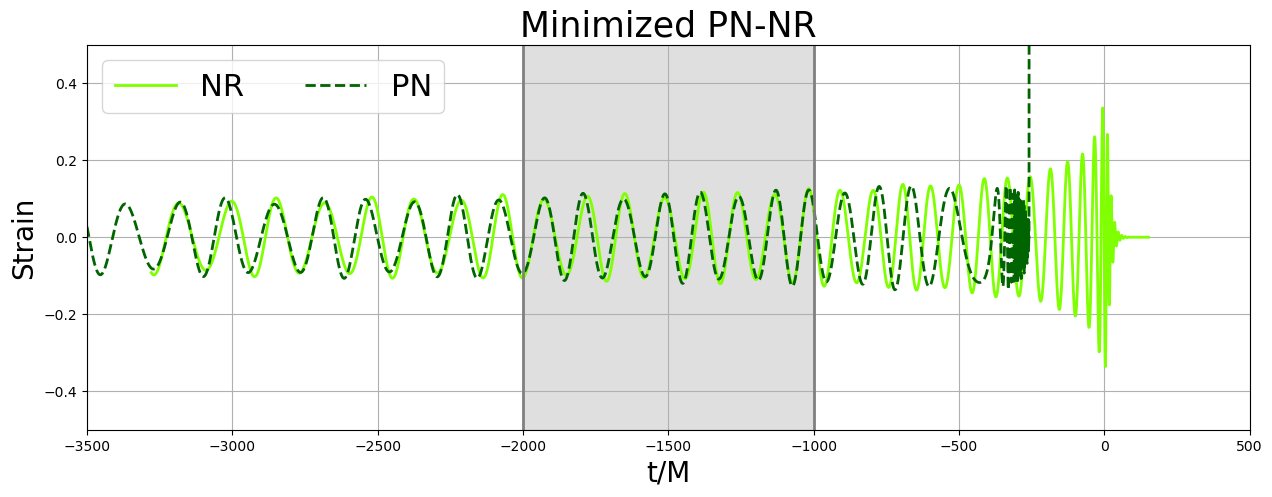

In [46]:
plt.figure(figsize=(15,5))
##plt.plot(tVec_NR_GM,hp_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI),color='lightcoral',linewidth=2,label='NR')
##plt.plot(tau_new[:maxPNidx],hpVec_PN_phaseshifted[:],color='brown',linestyle='--',linewidth=2,label='PN')  ## for  EccTD+Ebersold hybrid
#plt.plot(tau_new[:],hpVec_PN_phaseshifted[:],color='brown',linestyle='--',linewidth=2,label='PN')  ## for full EccTD hybrid

plt.plot(tVec_NR_GM,hc_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI),color='chartreuse',linewidth=2,label='NR')
plt.plot(tau_new[:maxPNidx],hcVec_PN_phaseshifted[:],color='darkgreen',linestyle='--',linewidth=2,label='PN')  ## for  EccTD+Ebersold hybrid
#plt.plot(tau_new[:],hcVec_PN_phaseshifted[:],color='darkgreen',linestyle='--',linewidth=2,label='PN')  ## for full EccTD hybrid
#plt.title("Minimized PN-NR (EccTD+Ebersold)", fontsize=25)
plt.title("Minimized PN-NR", fontsize=25)
plt.ylabel("Strain", fontsize=20)
plt.xlabel("t/M", fontsize=20)

plt.axvline(x=tVec_NR_GM[int(t1Idx_NR)],linewidth=2, color='gray')
plt.axvline(x=tVec_NR_GM[int(t2Idx_NR)],linewidth=2, color='gray')
plt.axvspan(tVec_NR_GM[int(t1Idx_NR)], tVec_NR_GM[int(t2Idx_NR)],  alpha=0.5, color='silver')

plt.ylim(ymax=0.5)
plt.ylim(ymin=-0.5)
plt.xlim(xmin=-3500)
plt.xlim(xmax=500)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.legend(loc=2,prop={'size': 22},ncol=2)
plt.grid()
#plt.savefig('1364_tNRzero_to_neg1000_full_EccTD.png',dpi=600)
#plt.savefig('1372_EccTD_hybridization_new.png',dpi=600)

In [47]:
hyb_time=[]
hyb_hp=[]
hyb_hc=[]

T1_PN=t1Idx_PN
T2_PN=t2Idx_PN

T1_NR=t1Idx_NR
T2_NR=t2Idx_NR

In [48]:
for i in tau_new[:T1_PN+timeshiftIdx_min]:
    hyb_time.append(i)

for i in hpVec_PN_phaseshifted[:T1_PN+timeshiftIdx_min]:
    hyb_hp.append(i)
    
for i in hcVec_PN_phaseshifted[:T1_PN+timeshiftIdx_min]:
    hyb_hc.append(i)

for i,j in tqdm(zip(range(T1_NR,T2_NR), range((T1_PN+timeshiftIdx_min),(T2_PN+timeshiftIdx_min)))):
    tau=float((tVec_NR_GM[i]-tVec_NR_GM[int(T1_NR)])/(tVec_NR_GM[int(T2_NR)]-tVec_NR_GM[int(T1_NR)]))
    hpval=tau*hp_NR_int[i]/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hpVec_PN_phaseshifted[j])
    hcval=tau*hc_NR_int[i]/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hcVec_PN_phaseshifted[j])
    
    hyb_hp.append(hpval)
    hyb_hc.append(hcval)
    hyb_time.append(tVec_NR_GM[i])

In [49]:
for i,j in tqdm(zip(range(T1_NR,T2_NR), range((T1_PN+timeshiftIdx_min),(T2_PN+timeshiftIdx_min)))):
    tau=float((tVec_NR_GM[i]-tVec_NR_GM[int(T1_NR)])/(tVec_NR_GM[int(T2_NR)]-tVec_NR_GM[int(T1_NR)]))
    hpval=tau*hp_NR_int[i]/((G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hpVec_PN_phaseshifted[j])
    hcval=tau*hc_NR_int[i]/((G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hcVec_PN_phaseshifted[j])
    
    hyb_hp.append(hpval)
    hyb_hc.append(hcval)
    hyb_time.append(tVec_NR_GM[i])

1333it [00:00, 329930.79it/s]


for i in tVec_NR_GM[T2_NR:]:
    hyb_time.append(i)
for i in hp_NR_int[T2_NR:]:
    hyb_hp.append(i/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
for i in hc_NR_int[T2_NR:]:
    hyb_hc.append(i/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))

In [50]:
for i in tVec_NR_GM[T2_NR:]:
    hyb_time.append(i)
for i in hp_NR_int[T2_NR:]:
    hyb_hp.append(i/((G_SI*M_SI/D_SI/C_SI/C_SI)))
for i in hc_NR_int[T2_NR:]:
    hyb_hc.append(i/((G_SI*M_SI/D_SI/C_SI/C_SI)))

plt.figure(figsize=(15,5))
plt.plot(hyb_time,np.real(hyb_hp))
plt.plot(hyb_time,np.real(hyb_hc))
plt.plot(hyb_time,np.abs(np.real(hyb_hp)+1j*np.real(hyb_hc)))
plt.plot(tVec_NR_GM,hp_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,hc_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,abs(hp_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+1j*hc_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))),'--')
#plt.plot(hpVec_PN.sample_times/(MTSUN_SI)+3000,hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.xlim(xmin=-1000)

(-3500.0, 500.0)

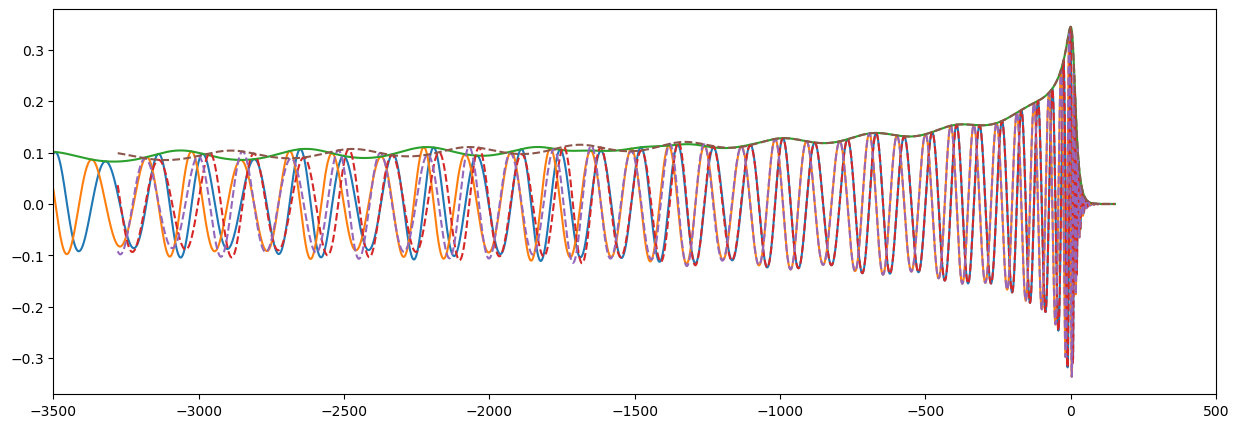

In [51]:
plt.figure(figsize=(15,5))
plt.plot(hyb_time,np.real(hyb_hp))
plt.plot(hyb_time,np.real(hyb_hc))
plt.plot(hyb_time,np.abs(np.real(hyb_hp)+1j*np.real(hyb_hc)))
plt.plot(tVec_NR_GM,hp_NR_int/((G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,hc_NR_int/((G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,abs(hp_NR_int/((G_SI*M_SI/D_SI/C_SI/C_SI))+1j*hc_NR_int/((G_SI*M_SI/D_SI/C_SI/C_SI))),'--')
#plt.plot(hpVec_PN.sample_times/(MTSUN_SI)+3000,hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.xlim(xmin=-3500)
plt.xlim(xmax=500)

### Saving hybrids to an HDF file

In [52]:
print(len(hyb_hp),len(hyb_hc),len(hyb_time))

43644 43644 43644


In [53]:
DataArray = np.transpose([hyb_time, np.real(hyb_hp), np.real(hyb_hc)])

In [54]:
hf = h5py.File('/home/pratul/Downloads/Project/New hybrids/TT2_Hybs/'+sims+'_TT2_Ebersold_22_hyb.h5', 'a') ## change name of file to be created as required

In [55]:
#hf.create_dataset('l2_m2', data=DataArray)
hf.create_dataset(mode, data=DataArray)

<HDF5 dataset "l2_m2": shape (43644, 3), type "<f8">

In [56]:
hf.close()

### Checking the HDF file

In [57]:
hf = h5py.File('/home/pratul/Downloads/Project/New hybrids/TT2_Hybs/'+sims+'_TT2_Ebersold_22_hyb.h5','r')

In [58]:
print(hf.keys())

<KeysViewHDF5 ['l2_m2']>


In [59]:
testd = hf.get(mode)

In [60]:
print(len(testd[:,0]),testd[0,0])

43644 -32588.78935081781


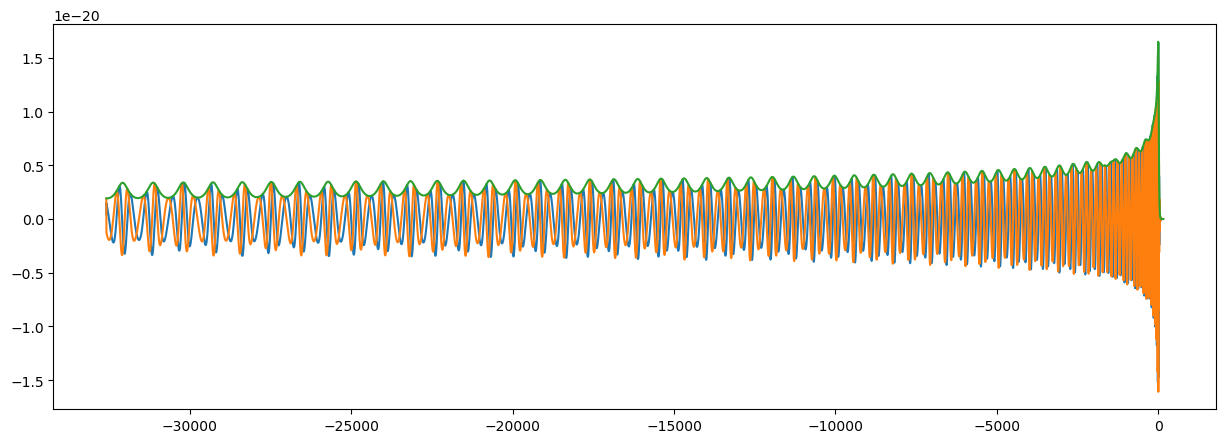

In [61]:
plt.figure(figsize=(15,5))
plt.plot(testd[:,0],testd[:,1]*G_SI*M_SI/D_SI/C_SI/C_SI)
plt.plot(testd[:,0],testd[:,2]*G_SI*M_SI/D_SI/C_SI/C_SI)
plt.plot(testd[:,0],np.abs(testd[:,1]*G_SI*M_SI/D_SI/C_SI/C_SI +1j*testd[:,2]*G_SI*M_SI/D_SI/C_SI/C_SI))
#plt.xlim(xmin=-1000)

In [62]:
hf.close()